# Predicting the Quality of a Wine

A collection of wine featuers is used to develop a model to predict the quality of the wine.  See the bottom of this notebook to see a citation of where this data was produced.

## Analysis Outline
1. Looking at the imported data
2. Testing models against data
3. Refining the Data Sets
4. Choosing the final model

### 1. Looking at the Data
The white wine data was picked for the intial analysis.  There is roughly 3.5 times more white wine entries than red wine.  Each feature is plotted against each other feature in the data set and the average of each feature at each quality classifer is also plotted with error bars shown by the standard deviation.  The amount of variation is much larger than trends in the features increasing the importance of having larger data sets.

### 2. Testing the Models Against Data

5 classifier models, 6 regression models and a neural network are tested. Those models are: 
##### Classifiers:
1. Naive Bayes
2. Gradient Boosting
3. Random Forest
4. KNeighbors
5. Support Vector Machine

##### Regression
1. Lasso
2. Elastic Net
3. Ridge
4. Support Vector Machine
5. Random Forest
6. Gradient Boosting

##### Neural Network
A Multi-layer Perceptron included in sklearn is used for classifer and regression modeling

The models are tested against feature sets defined by feature correlation to the quality classifier.

### 3. Refining the Data Sets
The Random Forest and Gradient Boosting models are used to test the data sets conditioned by outlier routines and principal component analysis.  Outlier searches used are:
##### Outlier Routines
1. Local Outlier Factor
2. Isolation Forest

A small imporvement is found in the Isolation Forest routine. 

### 4. Choosing the Final Model
The final model is a Random Forest model built upon the white wine data set with outliers as defined by the Isolation Forest routine removed from the data set.  

![Final Model](Final_Stat.png)

### Results from Paper
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

![Paper_Matrix](Paper_Matrix.png)

### Results from this Analysis

This is done with a 0.5 tolerance against the regression Random Forest model trained against 20 subsets of 80% of the Isolation Forest trimmed datasets.  The classifications were assigned as: if abs(predicted - actual) < 0.5 then prediction = actual, else prediction = floor(prediction - 0.5)  

![RFM](Random_Tree_ISF_Set_Matrix.png)

In [2]:
import matplotlib.pyplot as plt
import pandas            as pds
import seaborn           as sns
import numpy             as np
import sklearn           as sk
import math
import pickle

#Classification Modeling
from sklearn.naive_bayes     import GaussianNB as GNB
from sklearn.ensemble        import GradientBoostingClassifier as GBC, RandomForestClassifier as RFC
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier as KNC
#Regression Modeling
from sklearn.linear_model    import Lasso as LSO, ElasticNet as ELN, Ridge as RDG
from sklearn.svm             import SVR
from sklearn.ensemble        import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR
#Neural Network Modeling
from sklearn.neural_network  import MLPClassifier as MLPC, MLPRegressor as MLPR
from sklearn.preprocessing   import StandardScaler as ss
#Dimensionality
from sklearn.decomposition   import PCA
from sklearn.manifold        import SpectralEmbedding as SE, Isomap as IM
#Outlier Detection
from sklearn.neighbors       import LocalOutlierFactor as LOF
from sklearn.ensemble        import IsolationForest as ISF
from sklearn.covariance      import EllipticEnvelope as ELE
#Testing
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics         import classification_report as cr, r2_score as r2
from sklearn.metrics         import accuracy_score as ac, mean_squared_error as mse
from sklearn.metrics         import confusion_matrix as cm

# 1. Looking at the Data

We have two data lists one white wines and the other red wines, lets have a look, see if there isn't a sensible place to start with this analysis

In [3]:
df_white = pds.read_csv("winequality-white.csv", sep=";", header=0)
print("Total Size of White Wine List: ", df_white.shape[0], "\n")
print('\033[4m'+"Missing Data in Each Feature"+'\033[0m')
for key in df_white:
    print('{0: <22}'.format(key), ": ", df_white[key][df_white[key].isnull() == True].count())
print('\n\033[4m'+"Data Type of Each Feature"+'\033[0m')
print(df_white.dtypes)

Total Size of White Wine List:  4898 

Missing Data in Each Feature
fixed acidity          :  0
volatile acidity       :  0
citric acid            :  0
residual sugar         :  0
chlorides              :  0
free sulfur dioxide    :  0
total sulfur dioxide   :  0
density                :  0
pH                     :  0
sulphates              :  0
alcohol                :  0
quality                :  0

Data Type of Each Feature
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


### White Wine Feature Distribution

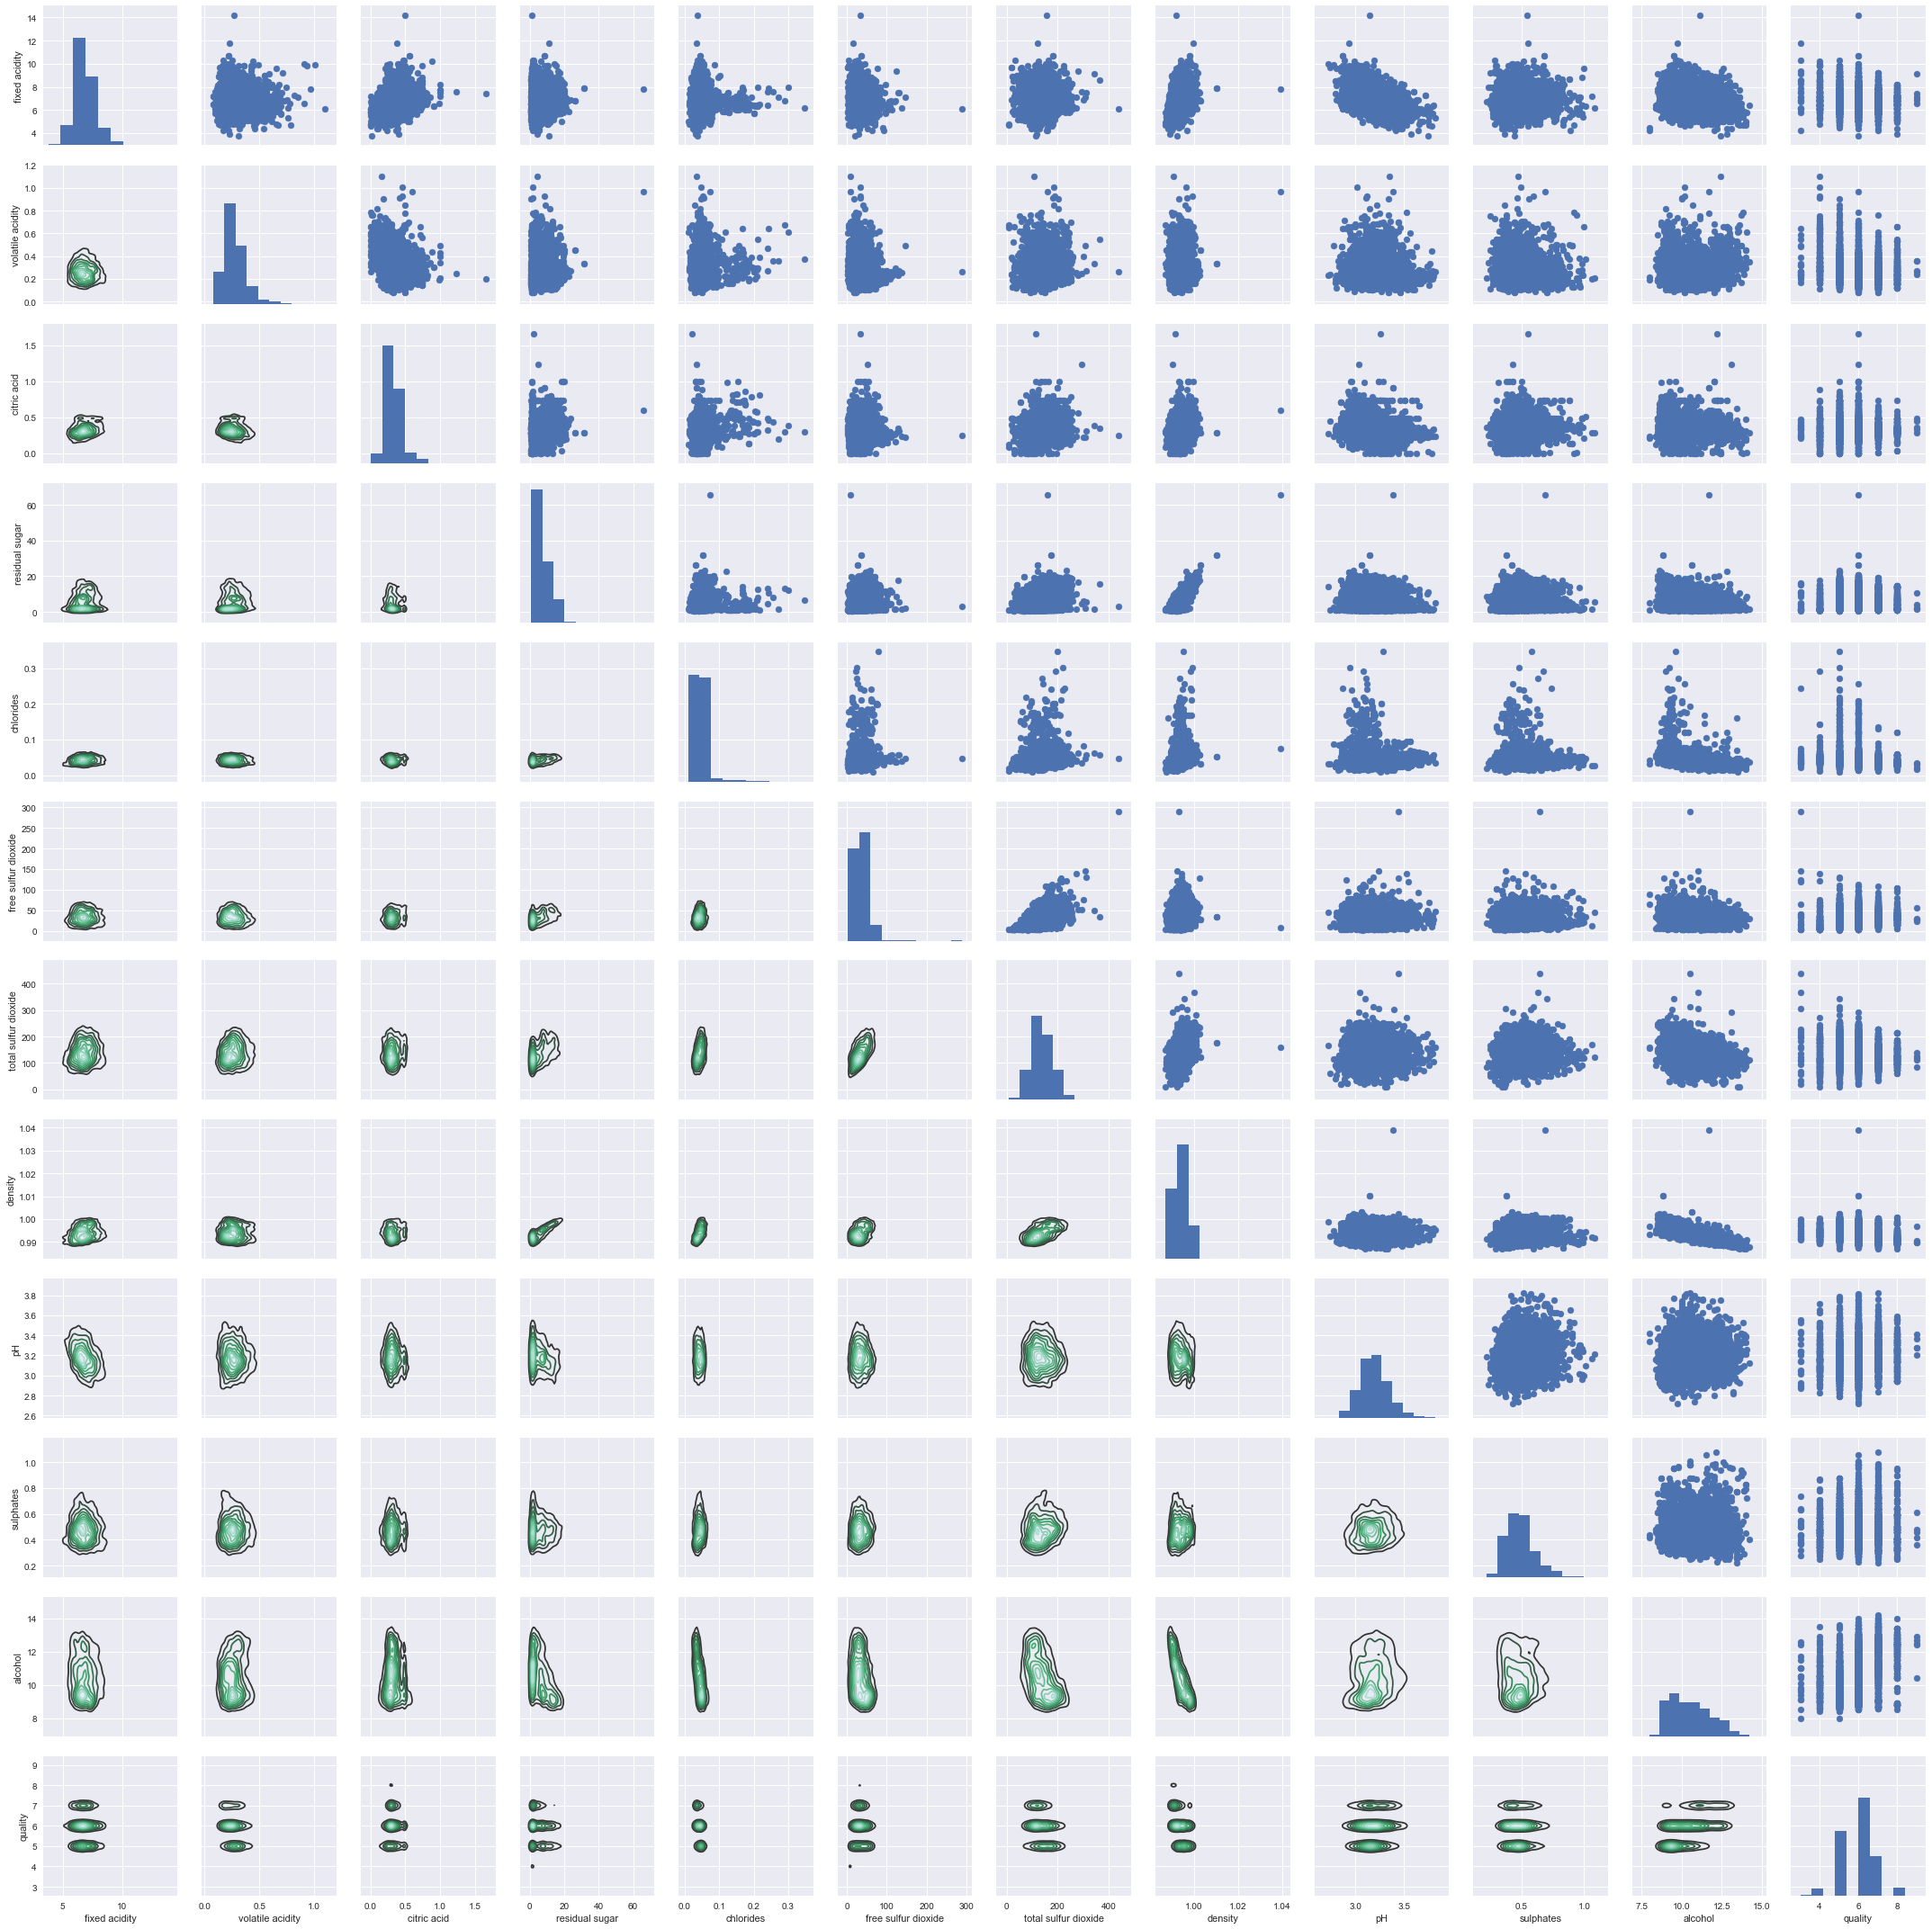

In [10]:
g = sns.PairGrid(df_white)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
plt.show()

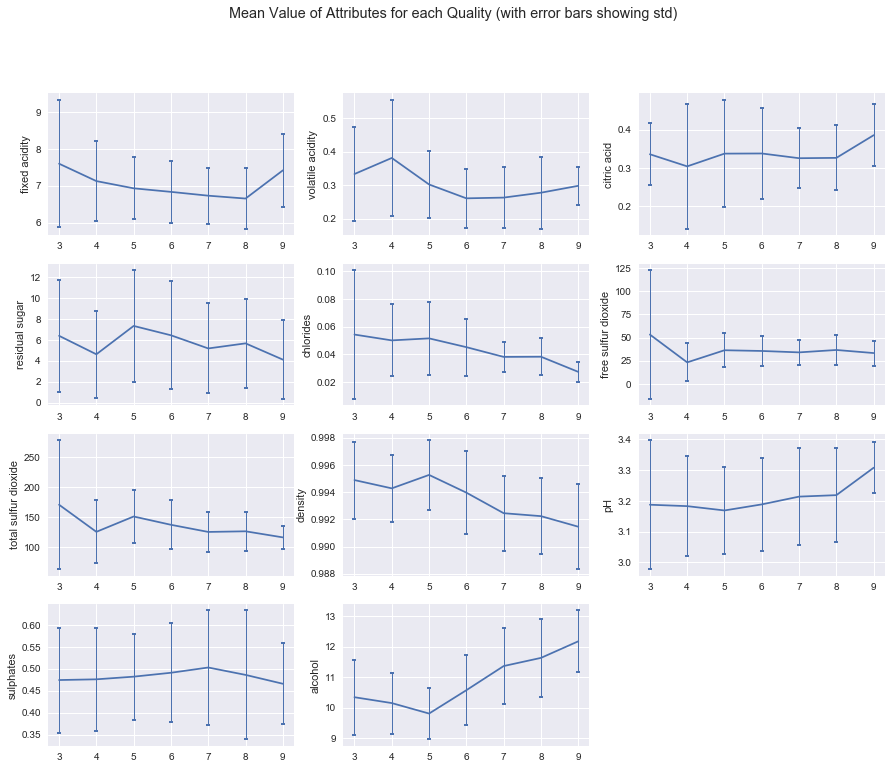

In [75]:
index = 0
for name in df_white.columns[:-1]:
    index += 1
    mean    = df_white.groupby('quality')[name].mean().values
    quality = df_white.groupby('quality')[name].mean().keys()
    std     = df_white.groupby('quality')[name].std().values
    yerr    = df_white.groupby('quality')[name].std().values / \
              df_white.groupby('quality')[name].count().apply(lambda x: math.sqrt(x)).values
    
    plt.figure(2, figsize=(15, 12))
    plt.subplot(4,3,index)
    plt.ylabel(name)
    plt.errorbar(quality, mean, yerr=std, capsize=2, capthick=2, elinewidth=1)

plt.suptitle('Mean Value of Attributes for each Quality (with error bars showing std)')
plt.show()

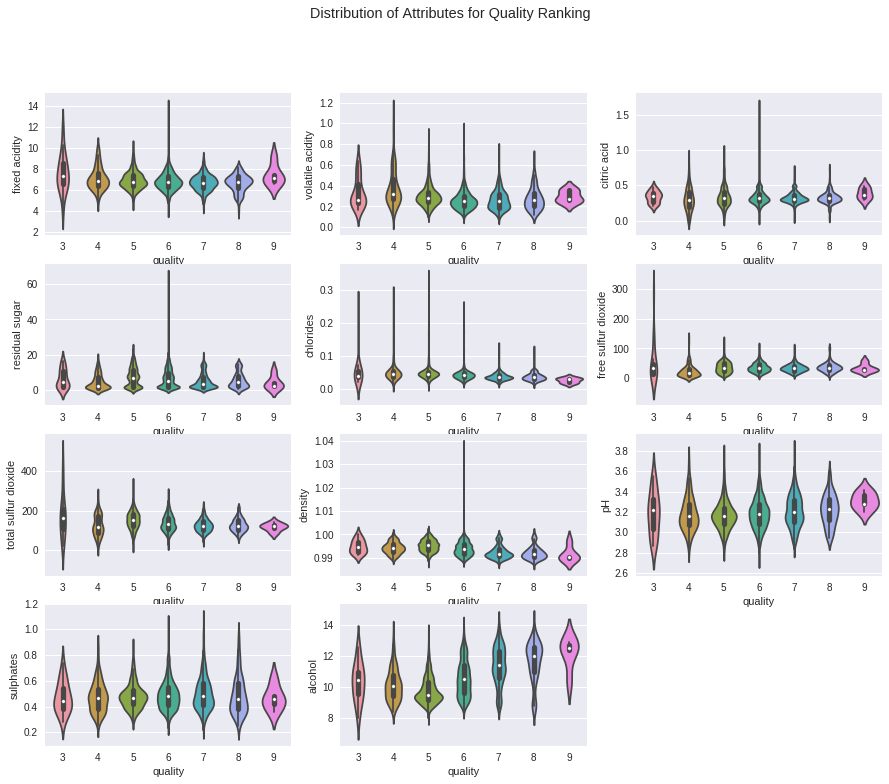

In [243]:
index = 0
for name in df_white.columns[:-1]:
    plt.figure(1, figsize=(15, 12))
    index += 1
    plt.subplot(4,3,index)
    plt.ylabel(name)
    
    sns.violinplot(x=df_white['quality'], y=df_white[name])
plt.suptitle('Distribution of Attributes for Quality Ranking')
plt.show()

## What are we looking at?

Well first thing we see in the large grid plot at the top of this section is that the data is not well correlated to anything.  There are a few outlier points in the data, that we can take a look at dealing with later one, once we have a model in hand, but for the most part the data seems to be grouped together.  

The next two plots show us how the quality classifiers track to the mean of each feature.  Unfortunately the spread in the standard deviation tends to overwhelm any trend seen in most of these. 


# 2. Testing Models Against Data

Given what we have seen so far, its going to be difficult to put together a model.  The data is messy and there is no way around it.  But lets move forward and see if we can't find something interesting.

I am going to be splitting the data into training and testing sets.  The training sets will be used to train various models and will represent 80% of the data.  The other 20% of the data will be used for testing to quantify to what degree the models can predicting the quality classifer

In [5]:
train_list = []; test_list = []; names = df_white.columns[:-1]
features_to_use = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}

for i in range(20):
    train, test = tts(df_white, test_size=0.2)
    train_list.append(train)
    test_list.append(test)

for name in names:
    if abs(df_white['quality'].corr(df_white[name])) > .30:
        features_to_use['strict'].append(name)
    if abs(df_white['quality'].corr(df_white[name])) > .20:
        features_to_use['strict-lose'].append(name)
    if abs(df_white['quality'].corr(df_white[name])) > .15:
        features_to_use['lose-strict'].append(name)
    if abs(df_white['quality'].corr(df_white[name])) > .09:
        features_to_use['lose'].append(name)
    if abs(df_white['quality'].corr(df_white[name])) > .00:
        features_to_use['none'].append(name)

## Classification Modeling

### Naive Gaussian Bayes Models

In [275]:
GNB_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = GNB()
        GNB_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality']))

### Support Vector Machine

In [276]:
SVC_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = SVC()
        SVC_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality']))  

### Random Forset

In [277]:
RFC_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = RFC()
        RFC_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality'])) 

### Gradient Tree Boosting

In [278]:
GBC_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = GBC()
        GBC_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality'])) 

### KNeighbor

In [279]:
KNC_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = KNC()
        KNC_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality']))   

## Testing the Models for Each Feature Set

### Strict Feature Set

In [280]:
key = 'strict'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
GNB_predicted = []; GBC_predicted = []; RFC_predicted = []
SVC_predicted = []; KNC_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    GNB_predicted.extend(GNB_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBC_predicted.extend(GBC_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFC_predicted.extend(RFC_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVC_predicted.extend(SVC_models[key][i].predict(test_list[i][features_to_use[key]]))
    KNC_predicted.extend(KNC_models[key][i].predict(test_list[i][features_to_use[key]]))

print('\n\n\033[4m'+'Naive Bayes'+'\033[0m'+'\n', cr(Expected, GNB_predicted))
print('\n\n\033[4m'+'Gradient Tree Boosting'+'\033[0m'+'\n', cr(Expected, GBC_predicted))
print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n', cr(Expected, RFC_predicted))
print('\n\n\033[4m'+'Support Vector'+'\033[0m'+'\n', cr(Expected, SVC_predicted))
print('\n\n\033[4m'+'KNeighbors'+'\033[0m'+'\n', cr(Expected, KNC_predicted))

strict Feature Set


Naive Bayes
              precision    recall  f1-score   support

          3       0.00      0.00      0.00        88
          4       0.00      0.00      0.00       638
          5       0.47      0.68      0.55      5803
          6       0.50      0.44      0.47      8956
          7       0.37      0.36      0.37      3420
          8       0.00      0.00      0.00       673
          9       0.00      0.00      0.00        22

avg / total       0.43      0.47      0.44     19600



Gradient Tree Boosting
              precision    recall  f1-score   support

          3       0.07      0.02      0.03        88
          4       0.18      0.01      0.02       638
          5       0.55      0.53      0.54      5803
          6       0.52      0.71      0.60      8956
          7       0.49      0.22      0.31      3420
          8       0.50      0.11      0.18       673
          9       0.00      0.00      0.00        22

avg / total       0.51      0.52  

D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Strict Lose Feature Set

In [281]:
key = 'strict-lose'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
GNB_predicted = []; GBC_predicted = []; RFC_predicted = []
SVC_predicted = []; KNC_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    GNB_predicted.extend(GNB_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBC_predicted.extend(GBC_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFC_predicted.extend(RFC_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVC_predicted.extend(SVC_models[key][i].predict(test_list[i][features_to_use[key]]))
    KNC_predicted.extend(KNC_models[key][i].predict(test_list[i][features_to_use[key]]))

print('\n\n\033[4m'+'Naive Bayes'+'\033[0m'+'\n', cr(Expected, GNB_predicted))
print('\n\n\033[4m'+'Gradient Tree Boosting'+'\033[0m'+'\n', cr(Expected, GBC_predicted))
print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n', cr(Expected, RFC_predicted))
print('\n\n\033[4m'+'Support Vector'+'\033[0m'+'\n', cr(Expected, SVC_predicted))
print('\n\n\033[4m'+'KNeighbors'+'\033[0m'+'\n', cr(Expected, KNC_predicted))

strict-lose Feature Set


Naive Bayes
              precision    recall  f1-score   support

          3       0.00      0.00      0.00        88
          4       0.00      0.00      0.00       638
          5       0.48      0.59      0.53      5803
          6       0.50      0.40      0.44      8956
          7       0.36      0.54      0.43      3420
          8       0.00      0.00      0.00       673
          9       0.00      0.00      0.00        22

avg / total       0.43      0.45      0.43     19600



Gradient Tree Boosting
              precision    recall  f1-score   support

          3       0.00      0.00      0.00        88
          4       0.13      0.01      0.02       638
          5       0.56      0.50      0.53      5803
          6       0.52      0.72      0.61      8956
          7       0.48      0.27      0.34      3420
          8       0.61      0.12      0.21       673
          9       0.00      0.00      0.00        22

avg / total       0.52      0

D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Lose Strict Feature Set

In [282]:
key = 'lose-strict'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
GNB_predicted = []; GBC_predicted = []; RFC_predicted = []
SVC_predicted = []; KNC_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    GNB_predicted.extend(GNB_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBC_predicted.extend(GBC_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFC_predicted.extend(RFC_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVC_predicted.extend(SVC_models[key][i].predict(test_list[i][features_to_use[key]]))
    KNC_predicted.extend(KNC_models[key][i].predict(test_list[i][features_to_use[key]]))

print('\n\n\033[4m'+'Naive Bayes'+'\033[0m'+'\n', cr(Expected, GNB_predicted))
print('\n\n\033[4m'+'Gradient Tree Boosting'+'\033[0m'+'\n', cr(Expected, GBC_predicted))
print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n', cr(Expected, RFC_predicted))
print('\n\n\033[4m'+'Support Vector'+'\033[0m'+'\n', cr(Expected, SVC_predicted))
print('\n\n\033[4m'+'KNeighbors'+'\033[0m'+'\n', cr(Expected, KNC_predicted))

lose-strict Feature Set


Naive Bayes
              precision    recall  f1-score   support

          3       0.08      0.16      0.11        88
          4       0.30      0.15      0.20       638
          5       0.52      0.56      0.54      5803
          6       0.54      0.45      0.49      8956
          7       0.36      0.58      0.44      3420
          8       0.08      0.01      0.02       673
          9       0.00      0.00      0.00        22

avg / total       0.48      0.48      0.47     19600



Gradient Tree Boosting
              precision    recall  f1-score   support

          3       0.06      0.03      0.04        88
          4       0.35      0.09      0.14       638
          5       0.63      0.57      0.60      5803
          6       0.56      0.75      0.64      8956
          7       0.54      0.33      0.41      3420
          8       0.60      0.16      0.25       673
          9       0.00      0.00      0.00        22

avg / total       0.57      0

D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Lose Feature Set

In [283]:
key = 'lose'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
GNB_predicted = []; GBC_predicted = []; RFC_predicted = []
SVC_predicted = []; KNC_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    GNB_predicted.extend(GNB_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBC_predicted.extend(GBC_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFC_predicted.extend(RFC_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVC_predicted.extend(SVC_models[key][i].predict(test_list[i][features_to_use[key]]))
    KNC_predicted.extend(KNC_models[key][i].predict(test_list[i][features_to_use[key]]))

print('\n\n\033[4m'+'Naive Bayes'+'\033[0m'+'\n', cr(Expected, GNB_predicted))
print('\n\n\033[4m'+'Gradient Tree Boosting'+'\033[0m'+'\n', cr(Expected, GBC_predicted))
print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n', cr(Expected, RFC_predicted))
print('\n\n\033[4m'+'Support Vector'+'\033[0m'+'\n', cr(Expected, SVC_predicted))
print('\n\n\033[4m'+'KNeighbors'+'\033[0m'+'\n', cr(Expected, KNC_predicted))

lose Feature Set


Naive Bayes
              precision    recall  f1-score   support

          3       0.07      0.14      0.09        88
          4       0.25      0.16      0.19       638
          5       0.51      0.55      0.53      5803
          6       0.53      0.38      0.44      8956
          7       0.35      0.63      0.45      3420
          8       0.13      0.02      0.03       673
          9       0.00      0.00      0.00        22

avg / total       0.47      0.45      0.45     19600



Gradient Tree Boosting
              precision    recall  f1-score   support

          3       0.07      0.03      0.04        88
          4       0.35      0.12      0.18       638
          5       0.64      0.59      0.62      5803
          6       0.58      0.75      0.66      8956
          7       0.54      0.36      0.44      3420
          8       0.69      0.17      0.28       673
          9       0.00      0.00      0.00        22

avg / total       0.59      0.59    

D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### All Features

In [284]:
key = 'none'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
GNB_predicted = []; GBC_predicted = []; RFC_predicted = []
SVC_predicted = []; KNC_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    GNB_predicted.extend(GNB_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBC_predicted.extend(GBC_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFC_predicted.extend(RFC_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVC_predicted.extend(SVC_models[key][i].predict(test_list[i][features_to_use[key]]))
    KNC_predicted.extend(KNC_models[key][i].predict(test_list[i][features_to_use[key]]))

print('\n\n\033[4m'+'Naive Bayes'+'\033[0m'+'\n', cr(Expected, GNB_predicted))
print('\n\n\033[4m'+'Gradient Tree Boosting'+'\033[0m'+'\n', cr(Expected, GBC_predicted))
print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n', cr(Expected, RFC_predicted))
print('\n\n\033[4m'+'Support Vector'+'\033[0m'+'\n', cr(Expected, SVC_predicted))
print('\n\n\033[4m'+'KNeighbors'+'\033[0m'+'\n', cr(Expected, KNC_predicted))

none Feature Set


Naive Bayes
              precision    recall  f1-score   support

          3       0.17      0.32      0.22        88
          4       0.23      0.20      0.21       638
          5       0.51      0.54      0.53      5803
          6       0.52      0.35      0.42      8956
          7       0.34      0.66      0.45      3420
          8       0.15      0.02      0.04       673
          9       0.00      0.00      0.00        22

avg / total       0.46      0.44      0.43     19600



Gradient Tree Boosting
              precision    recall  f1-score   support

          3       0.10      0.07      0.08        88
          4       0.43      0.17      0.25       638
          5       0.64      0.60      0.62      5803
          6       0.59      0.75      0.66      8956
          7       0.56      0.37      0.45      3420
          8       0.67      0.20      0.31       673
          9       0.00      0.00      0.00        22

avg / total       0.60      0.60    

D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Regression Modeling

## Building the Models

### Lasso Regression

In [ ]:
LSO_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = LSO()
        LSO_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality']))

### Elastic Net

In [286]:
ELN_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = ELN()
        ELN_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality']))  

### Ridge Regression

In [287]:
RDG_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = RDG()
        RDG_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality'])) 

### Gradient Boosting

In [288]:
GBR_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = GBR()
        GBR_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality'])) 

### Support Vector Machine

In [289]:
SVR_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = SVR(kernel='rbf')
        SVR_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality']))   

### Random Forest

In [290]:
RFR_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        model = RFR()
        RFR_models[key].append(model.fit(training_set[features_to_use[key]], training_set['quality']))   

strict Feature Set


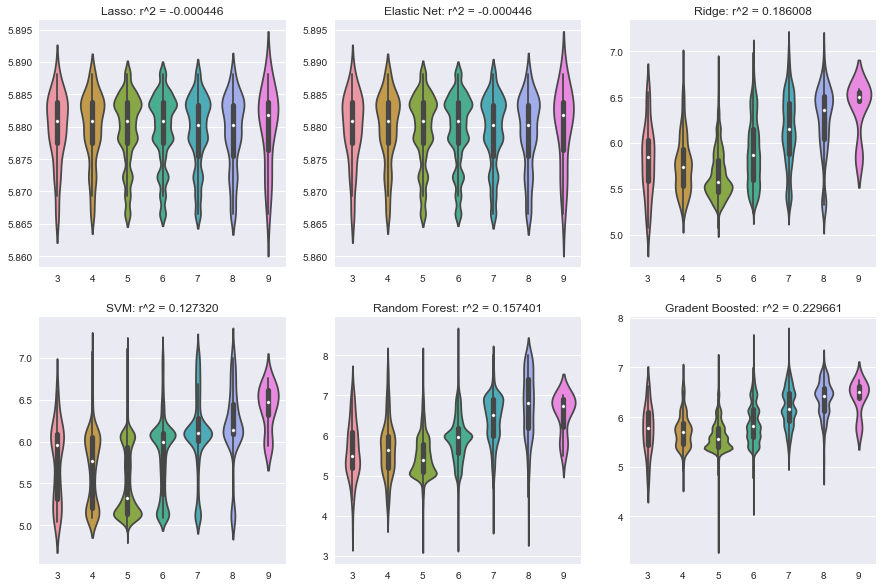

In [291]:
key = 'strict'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []
SVR_predicted = []; RFR_predicted = []; GBR_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    LSO_predicted.extend(LSO_models[key][i].predict(test_list[i][features_to_use[key]]))
    ELN_predicted.extend(ELN_models[key][i].predict(test_list[i][features_to_use[key]]))
    RDG_predicted.extend(RDG_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVR_predicted.extend(SVR_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFR_predicted.extend(RFR_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBR_predicted.extend(GBR_models[key][i].predict(test_list[i][features_to_use[key]]))

plt.figure(1, figsize=(15, 10))
r2(LSO_predicted, Expected)
plt.subplot(2,3,1); sns.violinplot(Expected, LSO_predicted) 
plt.title('Lasso: r^2 = {0:.6f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); sns.violinplot(Expected, ELN_predicted) 
plt.title('Elastic Net: r^2 = {0:.6f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); sns.violinplot(Expected, RDG_predicted); 
plt.title('Ridge: r^2 = {0:.6f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); sns.violinplot(Expected, SVR_predicted); 
plt.title('SVM: r^2 = {0:.6f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); sns.violinplot(Expected, RFR_predicted); 
plt.title('Random Forest: r^2 = {0:.6f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); sns.violinplot(Expected, GBR_predicted); 
plt.title('Gradent Boosted: r^2 = {0:.6f}'.format(r2(Expected, GBR_predicted)))
plt.show()

strict-lose Feature Set


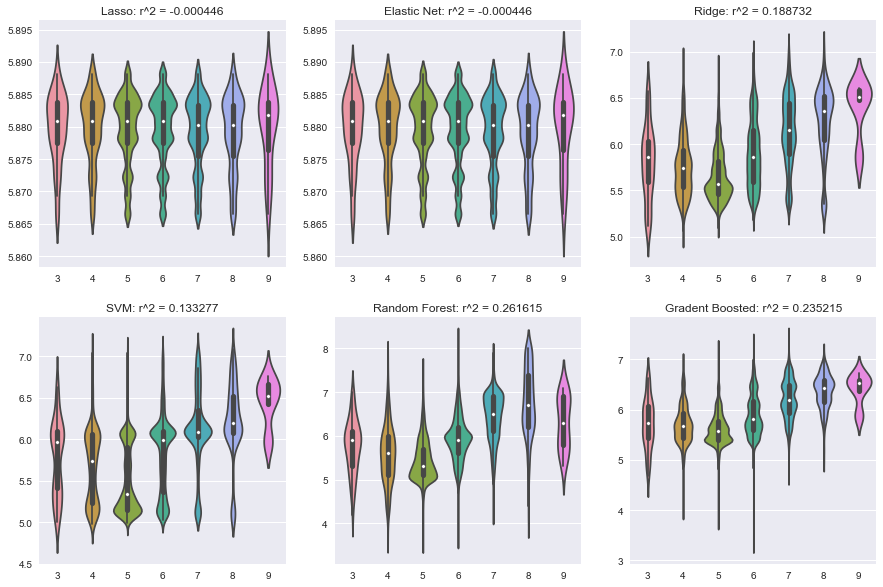

In [292]:
key = 'strict-lose'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []
SVR_predicted = []; RFR_predicted = []; GBR_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    LSO_predicted.extend(LSO_models[key][i].predict(test_list[i][features_to_use[key]]))
    ELN_predicted.extend(ELN_models[key][i].predict(test_list[i][features_to_use[key]]))
    RDG_predicted.extend(RDG_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVR_predicted.extend(SVR_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFR_predicted.extend(RFR_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBR_predicted.extend(GBR_models[key][i].predict(test_list[i][features_to_use[key]]))

plt.figure(1, figsize=(15, 10))
r2(LSO_predicted, Expected)
plt.subplot(2,3,1); sns.violinplot(Expected, LSO_predicted) 
plt.title('Lasso: r^2 = {0:.6f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); sns.violinplot(Expected, ELN_predicted) 
plt.title('Elastic Net: r^2 = {0:.6f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); sns.violinplot(Expected, RDG_predicted); 
plt.title('Ridge: r^2 = {0:.6f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); sns.violinplot(Expected, SVR_predicted); 
plt.title('SVM: r^2 = {0:.6f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); sns.violinplot(Expected, RFR_predicted); 
plt.title('Random Forest: r^2 = {0:.6f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); sns.violinplot(Expected, GBR_predicted); 
plt.title('Gradent Boosted: r^2 = {0:.6f}'.format(r2(Expected, GBR_predicted)))
plt.show()

lose-strict Feature Set


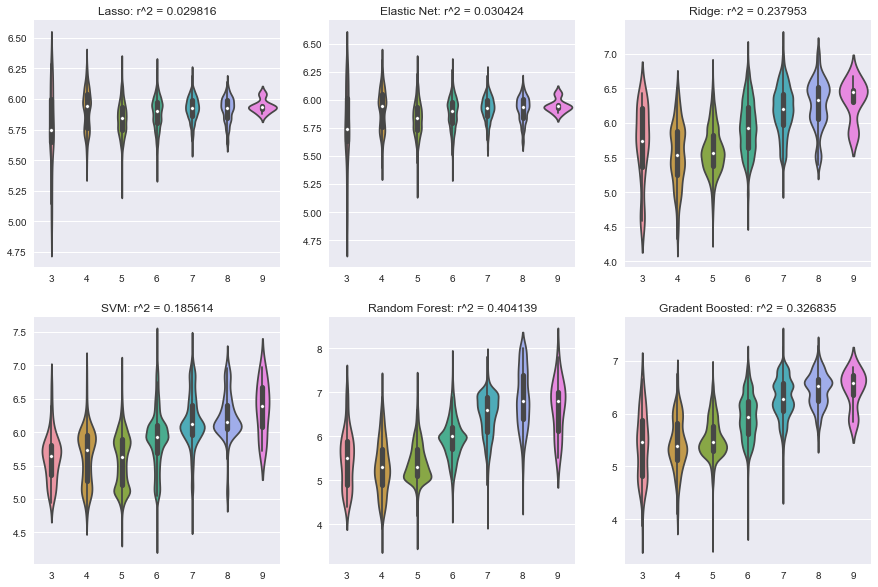

In [293]:
key = 'lose-strict'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []
SVR_predicted = []; RFR_predicted = []; GBR_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    LSO_predicted.extend(LSO_models[key][i].predict(test_list[i][features_to_use[key]]))
    ELN_predicted.extend(ELN_models[key][i].predict(test_list[i][features_to_use[key]]))
    RDG_predicted.extend(RDG_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVR_predicted.extend(SVR_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFR_predicted.extend(RFR_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBR_predicted.extend(GBR_models[key][i].predict(test_list[i][features_to_use[key]]))

plt.figure(1, figsize=(15, 10))
r2(LSO_predicted, Expected)
plt.subplot(2,3,1); sns.violinplot(Expected, LSO_predicted) 
plt.title('Lasso: r^2 = {0:.6f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); sns.violinplot(Expected, ELN_predicted) 
plt.title('Elastic Net: r^2 = {0:.6f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); sns.violinplot(Expected, RDG_predicted); 
plt.title('Ridge: r^2 = {0:.6f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); sns.violinplot(Expected, SVR_predicted); 
plt.title('SVM: r^2 = {0:.6f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); sns.violinplot(Expected, RFR_predicted); 
plt.title('Random Forest: r^2 = {0:.6f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); sns.violinplot(Expected, GBR_predicted); 
plt.title('Gradent Boosted: r^2 = {0:.6f}'.format(r2(Expected, GBR_predicted)))
plt.show()

lose Feature Set


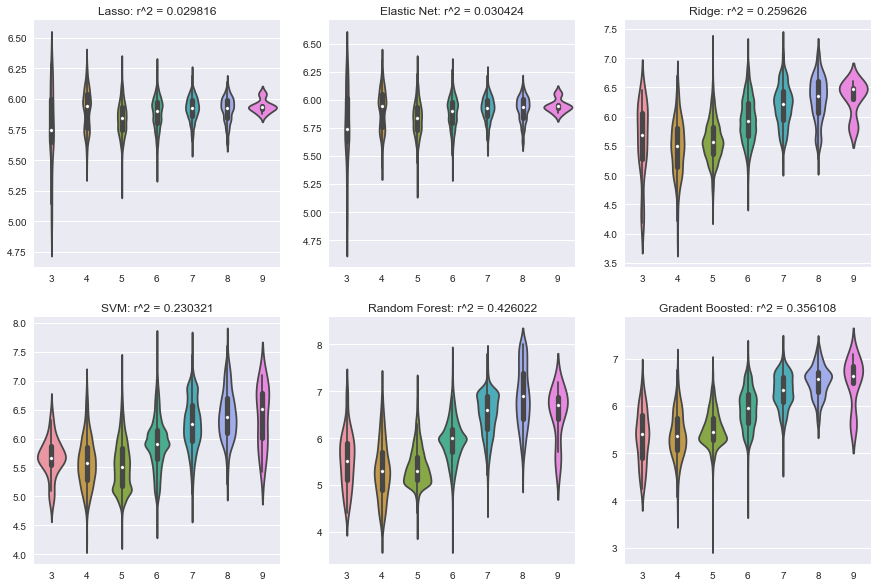

In [294]:
key = 'lose'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []
SVR_predicted = []; RFR_predicted = []; GBR_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    LSO_predicted.extend(LSO_models[key][i].predict(test_list[i][features_to_use[key]]))
    ELN_predicted.extend(ELN_models[key][i].predict(test_list[i][features_to_use[key]]))
    RDG_predicted.extend(RDG_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVR_predicted.extend(SVR_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFR_predicted.extend(RFR_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBR_predicted.extend(GBR_models[key][i].predict(test_list[i][features_to_use[key]]))

plt.figure(1, figsize=(15, 10))
r2(LSO_predicted, Expected)
plt.subplot(2,3,1); sns.violinplot(Expected, LSO_predicted) 
plt.title('Lasso: r^2 = {0:.6f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); sns.violinplot(Expected, ELN_predicted) 
plt.title('Elastic Net: r^2 = {0:.6f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); sns.violinplot(Expected, RDG_predicted); 
plt.title('Ridge: r^2 = {0:.6f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); sns.violinplot(Expected, SVR_predicted); 
plt.title('SVM: r^2 = {0:.6f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); sns.violinplot(Expected, RFR_predicted); 
plt.title('Random Forest: r^2 = {0:.6f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); sns.violinplot(Expected, GBR_predicted); 
plt.title('Gradent Boosted: r^2 = {0:.6f}'.format(r2(Expected, GBR_predicted)))
plt.show()

none Feature Set


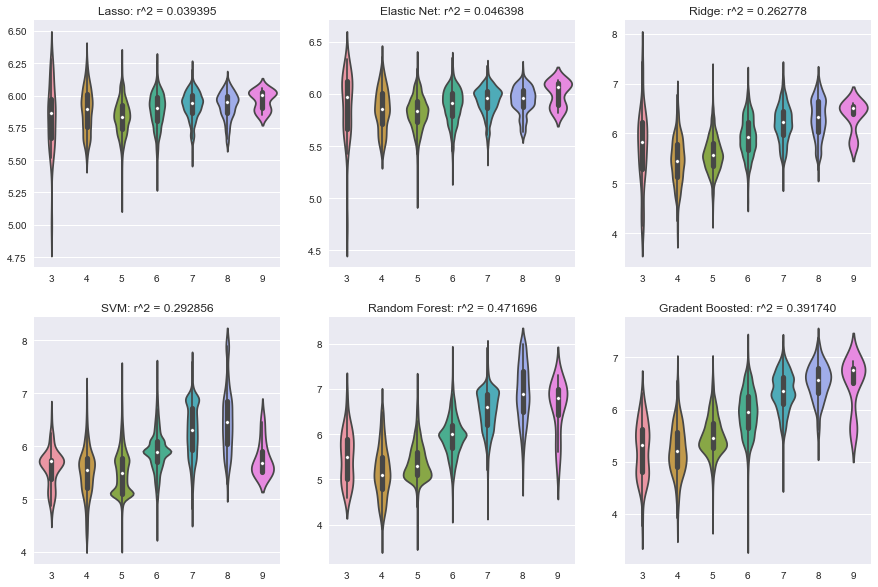

In [295]:
key = 'none'
print('\033[4m' + key + ' Feature Set' + '\033[0m')
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []
SVR_predicted = []; RFR_predicted = []; GBR_predicted = []; Expected      = []
# print(test_list[0]['quality'])
for i in range(len(test_list)):
    Expected.extend(test_list[i]['quality'].values)
    LSO_predicted.extend(LSO_models[key][i].predict(test_list[i][features_to_use[key]]))
    ELN_predicted.extend(ELN_models[key][i].predict(test_list[i][features_to_use[key]]))
    RDG_predicted.extend(RDG_models[key][i].predict(test_list[i][features_to_use[key]]))
    SVR_predicted.extend(SVR_models[key][i].predict(test_list[i][features_to_use[key]]))
    RFR_predicted.extend(RFR_models[key][i].predict(test_list[i][features_to_use[key]]))
    GBR_predicted.extend(GBR_models[key][i].predict(test_list[i][features_to_use[key]]))

plt.figure(1, figsize=(15, 10))
r2(LSO_predicted, Expected)
plt.subplot(2,3,1); sns.violinplot(Expected, LSO_predicted) 
plt.title('Lasso: r^2 = {0:.6f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); sns.violinplot(Expected, ELN_predicted) 
plt.title('Elastic Net: r^2 = {0:.6f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); sns.violinplot(Expected, RDG_predicted); 
plt.title('Ridge: r^2 = {0:.6f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); sns.violinplot(Expected, SVR_predicted); 
plt.title('SVM: r^2 = {0:.6f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); sns.violinplot(Expected, RFR_predicted); 
plt.title('Random Forest: r^2 = {0:.6f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); sns.violinplot(Expected, GBR_predicted); 
plt.title('Gradent Boosted: r^2 = {0:.6f}'.format(r2(Expected, GBR_predicted)))
plt.show()

# Neural Network Classifier and Regression

In [331]:
MLPC_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
MLPR_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
scalers     = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        MLPC_model = MLPC(solver='lbfgs')
#         MLPR_model = MLPR(solver='lbfgs')
        scaler = ss().fit(training_set[features_to_use[key]])
        scalers[key].append(scaler)
        nn_training_features = scaler.transform(training_set[features_to_use[key]])
        MLPC_models[key].append(MLPC_model.fit(nn_training_features, training_set['quality']))
#         MLPR_models[key].append(MLPR_model.fit(nn_training_features, training_set['quality']))

In [334]:
MLPC_predict = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}; 
Expected     = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for i in range(len(test_list)):
    for key in features_to_use:
        MLPC_predict[key].extend(MLPC_models[key][i].predict(scalers[key][i].transform(test_list[i][features_to_use[key]])))
        Expected[key].extend(test_list[i]['quality'])

# for key in Expected:
for key in features_to_use:
    print(key)
    print(cr(Expected[key], MLPC_predict[key]))

strict
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        88
          4       0.00      0.00      0.00       638
          5       0.53      0.53      0.53      5803
          6       0.50      0.70      0.59      8956
          7       0.45      0.16      0.23      3420
          8       0.00      0.00      0.00       673
          9       0.00      0.00      0.00        22

avg / total       0.46      0.51      0.47     19600

strict-lose
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        88
          4       0.00      0.00      0.00       638
          5       0.53      0.46      0.49      5803
          6       0.51      0.72      0.60      8956
          7       0.42      0.22      0.29      3420
          8       0.00      0.00      0.00       673
          9       0.00      0.00      0.00        22

avg / total       0.46      0.50      0.47     19600

lose-strict
         

D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [336]:
MLPC_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
MLPR_models = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
scalers     = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for training_set in train_list:
    for key in features_to_use:
        MLPR_model = MLPR(solver='lbfgs')
        scaler = ss().fit(training_set[features_to_use[key]])
        scalers[key].append(scaler)
        nn_training_features = scaler.transform(training_set[features_to_use[key]])
        MLPR_models[key].append(MLPR_model.fit(nn_training_features, training_set['quality']))

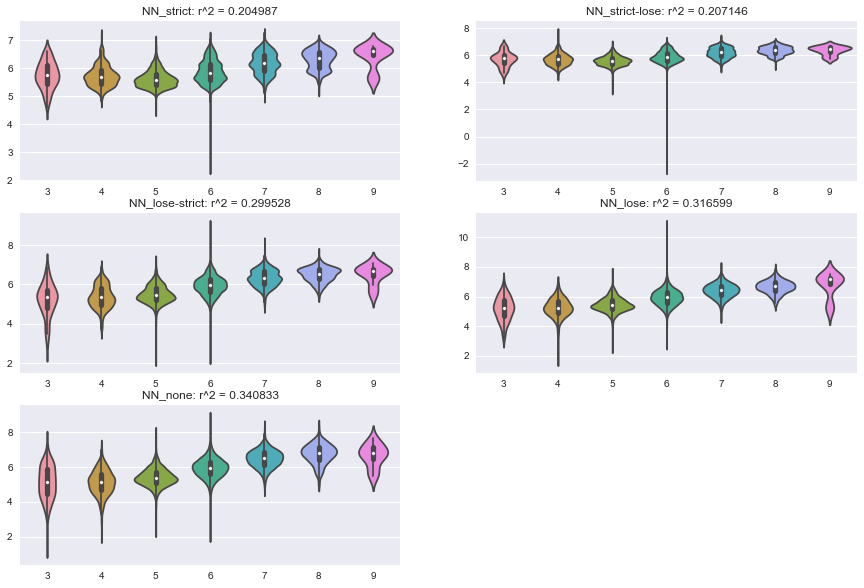

In [353]:
MLPR_predict = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}; 
Expected     = {'strict':[], 'strict-lose':[], 'lose-strict':[], 'lose':[], 'none':[]}
for i in range(len(test_list)):
    for key in features_to_use:
        MLPR_predict[key].extend(MLPR_models[key][i].predict(scalers[key][i].transform(test_list[i][features_to_use[key]])))
        Expected[key].extend(test_list[i]['quality'])

index = 0
for key in features_to_use:
    index += 1
    r2(MLPR_predict[key], Expected[key])
    plt.figure(1, figsize=(15, 10))
    plt.subplot(3,2,index)
    sns.violinplot(Expected[key], MLPR_predict[key]) 
    plt.title('NN_'+key+': r^2 = {0:.6f}'.format(r2(Expected[key], MLPR_predict[key])))
plt.show()

### Results of the Model Scan

Well in both the classifiers and regression analysis the Random Forest preformed best.  The regression with an r2 value of 0.47 and the classifier with an f1 = 0.64.  They are preforming better than random so there value to the analysis.  Lets see if we can't imporve that somewhat with a PCA and outlier detection.

# 3. Refining the Data Sets

We will create three sets.
1. Outliers removed
2. PCA preformed set
3. Ouliers removed then PAC preformed

Once done we can look at the effects of these three sets on the Random Forest and the Gradient Boosted Tree models

In [6]:
LOF_list = LOF().fit_predict(df_white)
ISF_fit  = ISF().fit(df_white)
ISF_list = ISF_fit.predict(df_white)

LOF_outliers = []; ISF_outliers = []
for i in range(len(LOF_list)):
    if LOF_list[i] == -1:
        LOF_outliers.append(i)
    if ISF_list[i] == -1:
        ISF_outliers.append(i)

print('number of points cut by LOF outlier search: ', len(LOF_outliers))
print('number of points cut by ISF outlier search: ', len(ISF_outliers))

df_LOF = df_white.drop(df_white.index[LOF_outliers])
df_LOF.index = range(len(df_LOF))
df_ISF = df_white.drop(df_white.index[ISF_outliers])
df_ISF.index = range(len(df_ISF))

LOF_PCA_list         = PCA().fit_transform(df_LOF[names])
ISF_PCA_list         = PCA().fit_transform(df_ISF[names])
PCA_list             = PCA().fit_transform(df_white[names])
df_LOF_PCA           = pds.DataFrame(LOF_PCA_list)
df_ISF_PCA           = pds.DataFrame(ISF_PCA_list)
df_PCA               = pds.DataFrame(PCA_list)
df_LOF_PCA['target'] = df_LOF['quality']
df_ISF_PCA['target'] = df_ISF['quality']
df_PCA['target']     = df_white['quality']

number of points cut by LOF outlier search:  490
number of points cut by ISF outlier search:  490


In [617]:
LOF_train_list     = []; LOF_test_list     = []
ISF_train_list     = []; ISF_test_list     = []
LOF_PCA_train_list = []; LOF_PCA_test_list = []
ISF_PCA_train_list = []; ISF_PCA_test_list = []
PCA_train_list     = []; PCA_test_list     = []
for i in range(20):
    train, test = tts(df_LOF, test_size=0.2)
    LOF_train_list.append(train)
    LOF_test_list.append(test)

    train, test = tts(df_ISF, test_size=0.2)
    ISF_train_list.append(train)
    ISF_test_list.append(test)
    
    train, test = tts(df_LOF_PCA, test_size=0.2)
    LOF_PCA_train_list.append(train)
    LOF_PCA_test_list.append(test)
    
    train, test = tts(df_ISF_PCA, test_size=0.2)
    ISF_PCA_train_list.append(train)
    ISF_PCA_test_list.append(test)
    
    train, test = tts(df_PCA, test_size=0.2)
    PCA_train_list.append(train)
    PCA_test_list.append(test)

### Running the Model with Only the LOF Outlier Set




Random Forest
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        43
          4       0.55      0.21      0.30       497
          5       0.66      0.70      0.68      5262
          6       0.64      0.73      0.68      7887
          7       0.67      0.54      0.60      3326
          8       0.82      0.36      0.50       616
          9       0.00      0.00      0.00         9

avg / total       0.66      0.66      0.65     17640



Gradient Boosted
             precision    recall  f1-score   support

          3       0.04      0.02      0.03        43
          4       0.43      0.16      0.24       497
          5       0.65      0.59      0.62      5262
          6       0.58      0.74      0.65      7887
          7       0.58      0.41      0.48      3326
          8       0.64      0.21      0.31       616
          9       0.00      0.00      0.00         9

avg / total       0.60      0.60      0.58     17640



D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


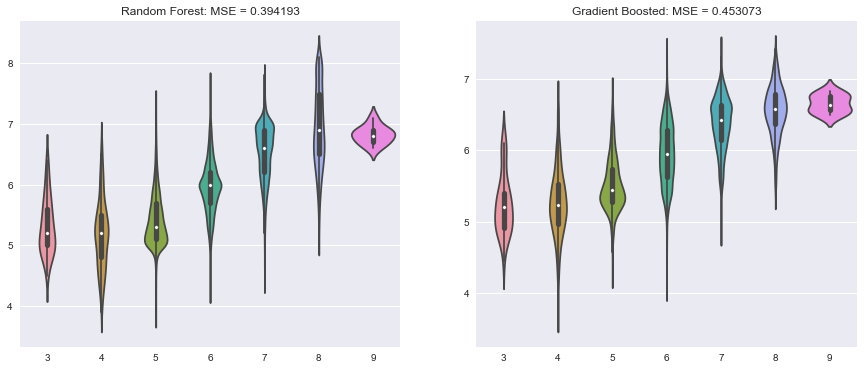

In [633]:
RFC_models = []; RFR_models = []; GBC_models = []; GBR_models = []
for training_set in LOF_train_list:
    RFC_models.append(RFC().fit(training_set[names], training_set['quality']))
    RFR_models.append(RFR().fit(training_set[names], training_set['quality']))
    GBC_models.append(GBC().fit(training_set[names], training_set['quality']))
    GBR_models.append(GBR().fit(training_set[names], training_set['quality']))

RFC_LOF_predicted = []; LOF_expected = []; RFR_LOF_predicted = []; GBC_LOF_predicted = []; GBR_LOF_predicted = []
for i in range(len(LOF_test_list)):
    RFC_LOF_predicted.extend(RFC_models[i].predict(LOF_test_list[i][names]))
    RFR_LOF_predicted.extend(RFR_models[i].predict(LOF_test_list[i][names]))
    GBC_LOF_predicted.extend(GBC_models[i].predict(LOF_test_list[i][names]))
    GBR_LOF_predicted.extend(GBR_models[i].predict(LOF_test_list[i][names]))
    LOF_expected.extend(LOF_test_list[i]['quality'])

print()
print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n'+cr(LOF_expected, RFC_LOF_predicted))
print('\n\n\033[4m'+'Gradient Boosted'+'\033[0m'+'\n'+cr(LOF_expected, GBC_LOF_predicted))
plt.figure(1, figsize=(15, 6))
plt.subplot(1,2,1)
sns.violinplot(LOF_expected, RFR_LOF_predicted)
plt.title('Random Forest: MSE = {0:.6f}'.format(mse(LOF_expected, RFR_LOF_predicted)))
plt.subplot(1,2,2)
sns.violinplot(LOF_expected, GBR_LOF_predicted)
plt.title('Gradient Boosted: MSE = {0:.6f}'.format(mse(LOF_expected, GBR_LOF_predicted)))
plt.show()

### Running the Model with Only the ISF Outlier Set

D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Random Forest
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        23
          4       0.52      0.16      0.25       353
          5       0.68      0.70      0.69      5289
          6       0.67      0.76      0.71      8208
          7       0.69      0.54      0.60      3305
          8       0.84      0.37      0.52       448
          9       0.00      0.00      0.00        14

avg / total       0.68      0.68      0.67     17640



Gradient Boosted
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        23
          4       0.22      0.06      0.10       353
          5       0.66      0.59      0.63      5289
          6       0.60      0.77      0.68      8208
          7       0.63      0.40      0.49      3305
          8       0.76      0.20      0.32       448
          9       0.00      0.00      0.00        14

avg / total       0.62      0.62      0.60     17640



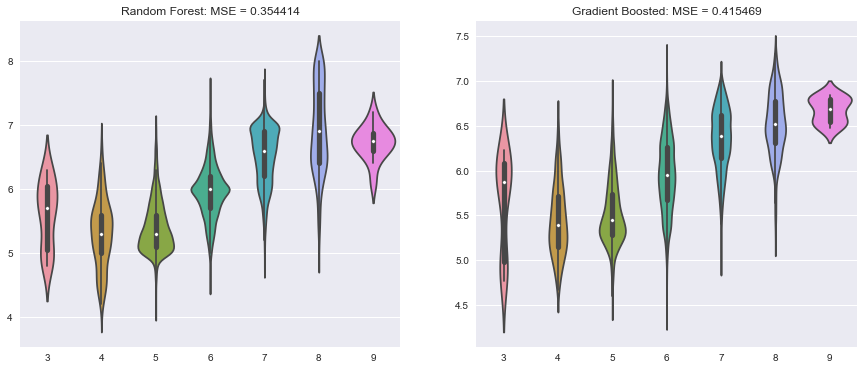

In [634]:
RFC_models = []; RFR_models = []; GBC_models = []; GBR_models = []
for training_set in ISF_train_list:
    RFC_models.append(RFC().fit(training_set[names], training_set['quality']))
    RFR_models.append(RFR().fit(training_set[names], training_set['quality']))
    GBC_models.append(GBC().fit(training_set[names], training_set['quality']))
    GBR_models.append(GBR().fit(training_set[names], training_set['quality']))

RFC_ISF_predicted = []; ISF_expected = []; RFR_ISF_predicted = []; GBC_ISF_predicted = []; GBR_ISF_predicted = []
for i in range(len(ISF_test_list)):
    RFC_ISF_predicted.extend(RFC_models[i].predict(ISF_test_list[i][names]))
    RFR_ISF_predicted.extend(RFR_models[i].predict(ISF_test_list[i][names]))
    GBC_ISF_predicted.extend(GBC_models[i].predict(ISF_test_list[i][names]))
    GBR_ISF_predicted.extend(GBR_models[i].predict(ISF_test_list[i][names]))
    ISF_expected.extend(ISF_test_list[i]['quality'])

print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n'+cr(ISF_expected, RFC_ISF_predicted))
print('\n\n\033[4m'+'Gradient Boosted'+'\033[0m'+'\n'+cr(ISF_expected, GBC_ISF_predicted))
plt.figure(1, figsize=(15, 6))
plt.subplot(1,2,1)
sns.violinplot(ISF_expected, RFR_ISF_predicted)
plt.title('Random Forest: MSE = {0:.6f}'.format(mse(ISF_expected, RFR_ISF_predicted)))
plt.subplot(1,2,2)
sns.violinplot(ISF_expected, GBR_ISF_predicted)
plt.title('Gradient Boosted: MSE = {0:.6f}'.format(mse(ISF_expected, GBR_ISF_predicted)))
plt.show()

### Running the Model with Only the PCA



Random Forest
             precision    recall  f1-score   support

          3       0.20      0.01      0.02        91
          4       0.58      0.21      0.31       698
          5       0.65      0.71      0.68      5727
          6       0.65      0.75      0.70      8795
          7       0.69      0.52      0.59      3522
          8       0.83      0.36      0.50       748
          9       0.00      0.00      0.00        19

avg / total       0.66      0.66      0.65     19600



Gradient Boosted
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        91
          4       0.04      0.51      0.07       698
          5       0.30      0.52      0.38      5727
          6       0.40      0.01      0.02      8795
          7       0.22      0.00      0.01      3522
          8       0.04      0.01      0.02       748
          9       0.00      0.00      0.00        19

avg / total       0.31      0.18      0.13     19600



D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


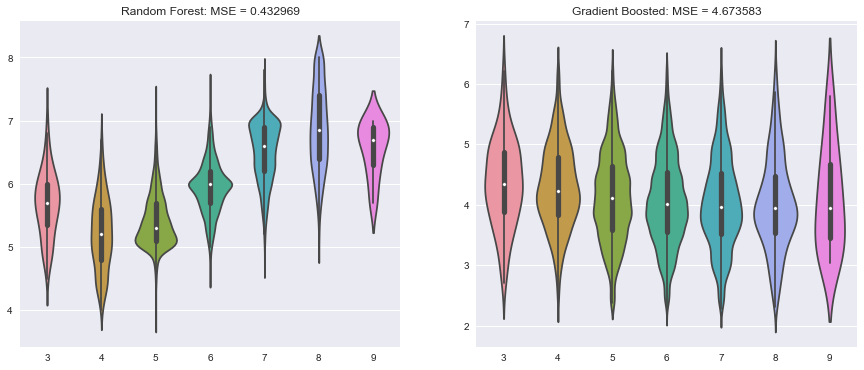

In [635]:
RFC_models = []; RFR_models = []
set_ = [0,1,2,3,4,5,6,7,8,9,10]

for training_set in PCA_train_list:
    RFC_models.append(RFC().fit(training_set[set_], training_set['target']))
    RFR_models.append(RFR().fit(training_set[set_], training_set['target']))
    GBC_models.append(GBC().fit(training_set[set_], training_set['target']))
    GBR_models.append(GBR().fit(training_set[set_], training_set['target']))

RFC_PCA_predicted = []; PCA_expected = []; RFR_PCA_predicted = []; GBC_PCA_predicted = []; GBR_PCA_predicted = []
for i in range(len(pca_test_list)):
    RFC_PCA_predicted.extend(RFC_models[i].predict(PCA_test_list[i][set_]))
    RFR_PCA_predicted.extend(RFR_models[i].predict(PCA_test_list[i][set_]))
    GBC_PCA_predicted.extend(GBC_models[i].predict(PCA_test_list[i][set_]))
    GBR_PCA_predicted.extend(GBR_models[i].predict(PCA_test_list[i][set_]))
    PCA_expected.extend(PCA_test_list[i]['target'])

print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n'+cr(PCA_expected, RFC_PCA_predicted))
print('\n\n\033[4m'+'Gradient Boosted'+'\033[0m'+'\n'+cr(PCA_expected, GBC_PCA_predicted))
plt.figure(1, figsize=(15, 6))
plt.subplot(1,2,1)
sns.violinplot(PCA_expected, RFR_PCA_predicted)
plt.title('Random Forest: MSE = {0:.6f}'.format(mse(PCA_expected, RFR_PCA_predicted)))
plt.subplot(1,2,2)
sns.violinplot(PCA_expected, GBR_PCA_predicted)
plt.title('Gradient Boosted: MSE = {0:.6f}'.format(mse(PCA_expected, GBR_PCA_predicted)))
plt.show()

### Running with the PCA and LOF Outliers Removed

D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Random Forest
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        48
          4       0.54      0.21      0.30       486
          5       0.66      0.70      0.68      5203
          6       0.66      0.74      0.70      8026
          7       0.69      0.54      0.61      3293
          8       0.87      0.38      0.53       572
          9       0.00      0.00      0.00        12

avg / total       0.67      0.66      0.66     17640



Gradient Boosted
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        48
          4       0.03      0.43      0.05       486
          5       0.29      0.50      0.37      5203
          6       0.49      0.01      0.03      8026
          7       0.11      0.00      0.00      3293
          8       0.04      0.02      0.02       572
          9       0.00      0.00      0.00        12

avg / total       0.33      0.17      0.12     17640



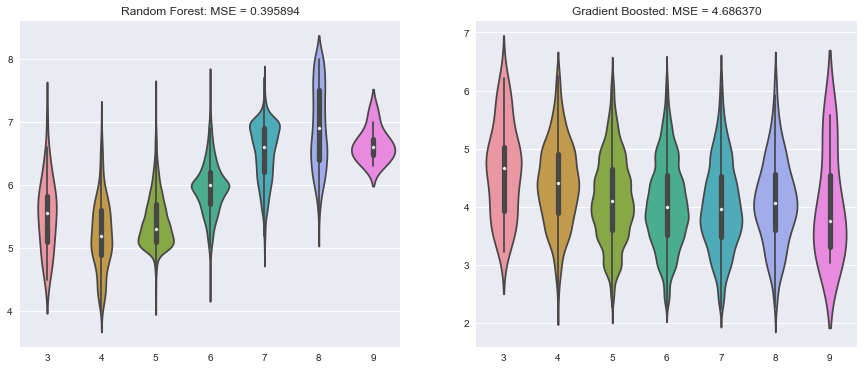

In [636]:
RFC_models = []; RFR_models = []
set_ = [0,1,2,3,4,5,6,7,8,9,10]

for training_set in LOF_PCA_train_list:
    RFC_models.append(RFC().fit(training_set[set_], training_set['target']))
    RFR_models.append(RFR().fit(training_set[set_], training_set['target']))
    GBC_models.append(GBC().fit(training_set[set_], training_set['target']))
    GBR_models.append(GBR().fit(training_set[set_], training_set['target']))

    RFC_LOF_PCA_predicted = []; LOF_PCA_expected = []; RFR_LOF_PCA_predicted = [] 
    GBC_LOF_PCA_predicted = []; GBR_LOF_PCA_predicted = []
for i in range(len(LOF_PCA_test_list)):
    RFC_LOF_PCA_predicted.extend(RFC_models[i].predict(LOF_PCA_test_list[i][set_]))
    RFR_LOF_PCA_predicted.extend(RFR_models[i].predict(LOF_PCA_test_list[i][set_]))
    GBC_LOF_PCA_predicted.extend(GBC_models[i].predict(LOF_PCA_test_list[i][set_]))
    GBR_LOF_PCA_predicted.extend(GBR_models[i].predict(LOF_PCA_test_list[i][set_]))
    LOF_PCA_expected.extend(LOF_PCA_test_list[i]['target'])

print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n'+cr(LOF_PCA_expected, RFC_LOF_PCA_predicted))
print('\n\n\033[4m'+'Gradient Boosted'+'\033[0m'+'\n'+cr(LOF_PCA_expected, GBC_LOF_PCA_predicted))
plt.figure(1, figsize=(15, 6))
plt.subplot(1,2,1)
sns.violinplot(LOF_PCA_expected, RFR_LOF_PCA_predicted)
plt.title('Random Forest: MSE = {0:.6f}'.format(mse(LOF_PCA_expected, RFR_LOF_PCA_predicted)))
plt.subplot(1,2,2)
sns.violinplot(LOF_PCA_expected, GBR_LOF_PCA_predicted)
plt.title('Gradient Boosted: MSE = {0:.6f}'.format(mse(LOF_PCA_expected, GBR_LOF_PCA_predicted)))
plt.show()

### Running with the PCA and ISF Outliers Removed

D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Random Forest
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        18
          4       0.68      0.17      0.28       343
          5       0.66      0.68      0.67      5197
          6       0.65      0.75      0.70      8224
          7       0.70      0.52      0.60      3348
          8       0.94      0.38      0.54       494
          9       0.00      0.00      0.00        16

avg / total       0.67      0.67      0.66     17640



Gradient Boosted
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        18
          4       0.02      0.44      0.04       343
          5       0.30      0.52      0.38      5197
          6       0.36      0.01      0.02      8224
          7       0.25      0.00      0.01      3348
          8       0.01      0.00      0.01       494
          9       0.00      0.00      0.00        16

avg / total       0.31      0.17      0.13     17640



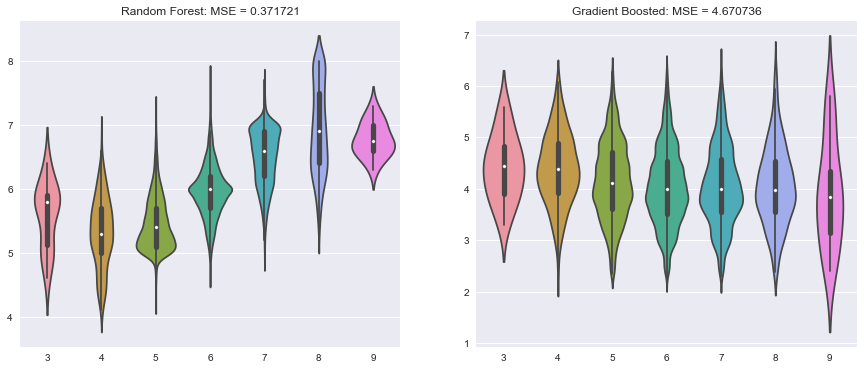

In [637]:
RFC_models = []; RFR_models = []
set_ = [0,1,2,3,4,5,6,7,8,9,10]


for training_set in ISF_PCA_train_list:
    RFC_models.append(RFC().fit(training_set[set_], training_set['target']))
    RFR_models.append(RFR().fit(training_set[set_], training_set['target']))
    GBC_models.append(GBC().fit(training_set[set_], training_set['target']))
    GBR_models.append(GBR().fit(training_set[set_], training_set['target']))

    RFC_ISF_PCA_predicted = []; ISF_PCA_expected = []; RFR_ISF_PCA_predicted = []
    GBC_ISF_PCA_predicted = []; GBR_ISF_PCA_predicted = []
for i in range(len(ISF_PCA_test_list)):
    RFC_ISF_PCA_predicted.extend(RFC_models[i].predict(ISF_PCA_test_list[i][set_]))
    RFR_ISF_PCA_predicted.extend(RFR_models[i].predict(ISF_PCA_test_list[i][set_]))
    GBC_ISF_PCA_predicted.extend(GBC_models[i].predict(ISF_PCA_test_list[i][set_]))
    GBR_ISF_PCA_predicted.extend(GBR_models[i].predict(ISF_PCA_test_list[i][set_]))
    ISF_PCA_expected.extend(ISF_PCA_test_list[i]['target'])

print('\n\n\033[4m'+'Random Forest'+'\033[0m'+'\n'+cr(ISF_PCA_expected, RFC_ISF_PCA_predicted))
print('\n\n\033[4m'+'Gradient Boosted'+'\033[0m'+'\n'+cr(ISF_PCA_expected, GBC_ISF_PCA_predicted))
plt.figure(1, figsize=(15, 6))
plt.subplot(1,2,1)
sns.violinplot(ISF_PCA_expected, RFR_ISF_PCA_predicted)
plt.title('Random Forest: MSE = {0:.6f}'.format(mse(ISF_PCA_expected, RFR_ISF_PCA_predicted)))
plt.subplot(1,2,2)
sns.violinplot(ISF_PCA_expected, GBR_ISF_PCA_predicted)
plt.title('Gradient Boosted: MSE = {0:.6f}'.format(mse(ISF_PCA_expected, GBR_ISF_PCA_predicted)))
plt.show()

# 4. Final Model

The ISF data set run with the Random Forest routine is the best preforming model.  Just for completeness sake, lets compare this to the model they developed in the paper this data was collected for

Accuracy: 0.8057 


             precision    recall  f1-score   support

          3       0.00      0.00      0.00        23
          4       0.17      0.58      0.26       353
          5       0.74      0.98      0.84      5289
          6       0.92      0.85      0.89      8208
          7       0.99      0.54      0.70      3305
          8       1.00      0.23      0.37       448
          9       0.00      0.00      0.00        14

avg / total       0.87      0.81      0.81     17640
 


[[   0    8   15    0    0    0    0]
 [   0  204  145    4    0    0    0]
 [  10    3 5161  115    0    0    0]
 [   0  918  320 6968    2    0    0]
 [   0   57 1244  226 1778    0    0]
 [   0    6  111  211   18  102    0]
 [   0    0    2   12    0    0    0]]


D:\orson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


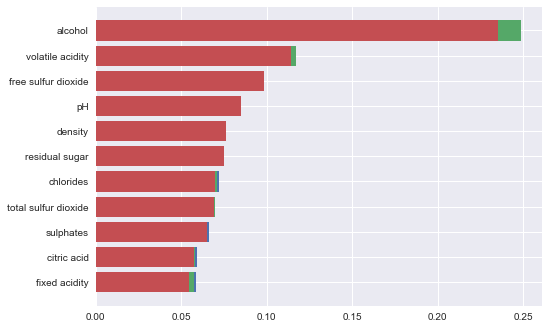

In [663]:
tol_limit = 0.5

tol_data = RFR_ISF_predicted.copy()
for i in range(len(tol_data)):
    if abs(tol_data[i] - ISF_expected[i]) < tol_limit:
        tol_data[i] = ISF_expected[i]
    else:
        tol_data[i] = math.floor(tol_data[i] - 0.5)
print('Accuracy: {0:.4f}'.format(ac(ISF_expected, tol_data)),'\n\n')
print(cr(ISF_expected, tol_data),'\n\n')
print(cm(ISF_expected, tol_data))

model = RFR().fit(df_ISF[names], df_ISF['quality'])
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_ISF.columns[sorted_idx])
plt.show()

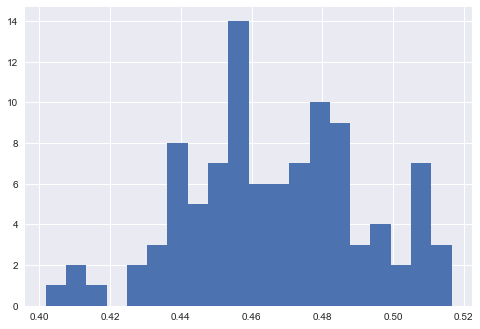

0.0250842711852
0.466652551103
54


In [21]:
training_list = []; testing_list = []
for i in range(100):
    train, test = tts(df_ISF, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
RFR_ISF_models = []; RFR_ISF_fit_list = []
for training_set in training_list:
    model = RFR(); RFR_ISF_models.append(model.fit(training_set[names], training_set['quality']))
for i in range(len(testing_list)):
    list_x = list(testing_list[i]['quality'])
    list_y = list(RFR_ISF_models[i].predict(testing_list[i][names]))
    RFR_ISF_fit_list.append(r2(list_x, list_y))

plt.hist(RFR_ISF_fit_list, bins=20) 
plt.show()

export_models = []
RFR_ISF_fit_array = np.asarray(RFR_ISF_fit_list)
RFR_ISF_fit_std   = np.std(RFR_ISF_fit_array)
RFR_ISF_fit_mean  = np.mean(RFR_ISF_fit_array)
for i in range(len(RFR_ISF_fit_array)):
    if abs(RFR_ISF_fit_array[i] - RFR_ISF_fit_mean) < RFR_ISF_fit_std/1.4142:
        export_models.append(RFR_ISF_models[i])
        
print(RFR_ISF_fit_std)
print(RFR_ISF_fit_mean)
print(len(export_models))
pickle.dump(export_models, open('Wine_final_models.p', 'wb'))

# Appendix A: Citing the Data Source

### 1. Title: Wine Quality 

#### 2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
#### 3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  In the above reference, two datasets were created, using red and white wine samples.
  The inputs include objective tests (e.g. PH values) and the output is based on sensory data
  (median of at least 3 evaluations made by wine experts). Each expert graded the wine quality 
  between 0 (very bad) and 10 (very excellent). Several data mining methods were applied to model
  these datasets under a regression approach. The support vector machine model achieved the
  best results. Several metrics were computed: MAD, confusion matrix for a fixed error tolerance (T),
  etc. Also, we plot the relative importances of the input variables (as measured by a sensitivity
  analysis procedure).
 
#### 4. Relevant Information:

   The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
   For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
   Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables 
   are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

   These datasets can be viewed as classification or regression tasks.
   The classes are ordered and not balanced (e.g. there are munch more normal wines than
   excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
   or poor wines. Also, we are not sure if all input variables are relevant. So
   it could be interesting to test feature selection methods. 

#### 5. Number of Instances: 
   red wine - 1599; white wine - 4898. 

#### 6. Number of Attributes: 
   11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

#### 7. Attribute information:

   For more information, read [Cortez et al., 2009].

   Input variables (based on physicochemical tests):
   1 - fixed acidity
   2 - volatile acidity
   3 - citric acid
   4 - residual sugar
   5 - chlorides
   6 - free sulfur dioxide
   7 - total sulfur dioxide
   8 - density
   9 - pH
   10 - sulphates
   11 - alcohol
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)

#### 8. Missing Attribute Values: 
   None
   
#### Citation Request:
  This dataset is public available for research. The details are described in [Cortez et al., 2009]. 
  Please include this citation if you plan to use this database:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

# Appendix C: Extra Code

In [42]:
df_red = pds.read_csv("winequality-red.csv", sep=';', header=0)
print("Total Size of Red Wine List: ", df_red.shape[0], "\n")
print('\033[4m'+"Missing Data in Each Feature"+'\033[0m')
for key in df_red:
    print('{0: <22}'.format(key), ": ", df_red[key][df_red[key].isnull() == True].count())
print('\n\033[4m'+"Data Type of Each Feature"+'\033[0m')
print(df_red.dtypes)

Total Size of Red Wine List:  1599 

Missing Data in Each Feature
fixed acidity          :  0
volatile acidity       :  0
citric acid            :  0
residual sugar         :  0
chlorides              :  0
free sulfur dioxide    :  0
total sulfur dioxide   :  0
density                :  0
pH                     :  0
sulphates              :  0
alcohol                :  0
quality                :  0

Data Type of Each Feature
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


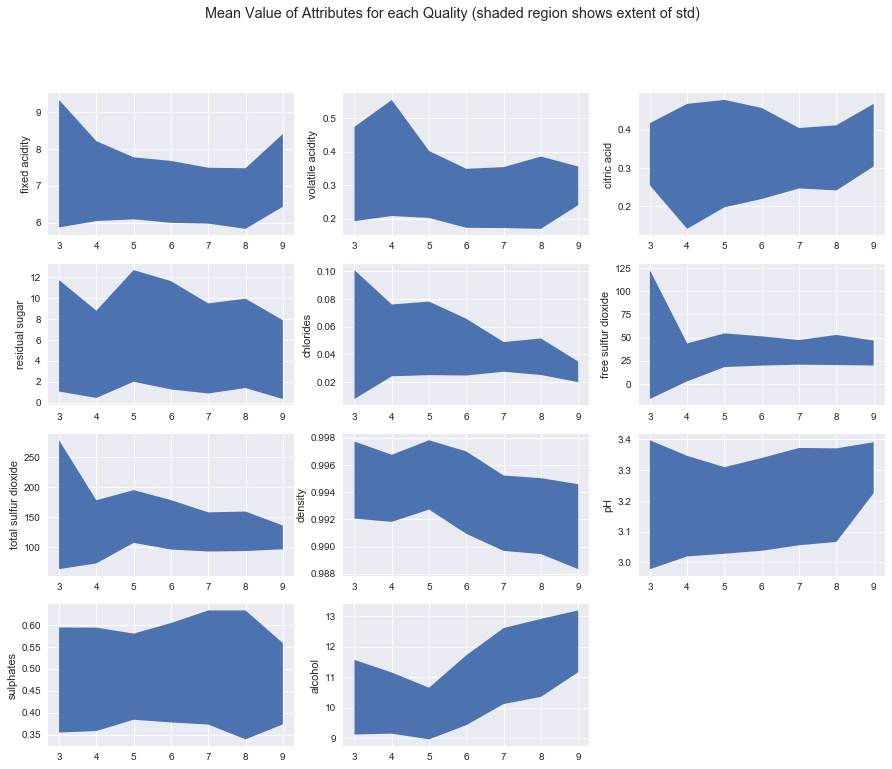

In [76]:
index = 0
for name in df_white.columns[:-1]:
    index += 1
    mean    = df_white.groupby('quality')[name].mean().values
    quality = df_white.groupby('quality')[name].mean().keys()
    std     = df_white.groupby('quality')[name].std().values
    yerr    = df_white.groupby('quality')[name].std().values / \
    df_white.groupby('quality')[name].count().apply(lambda x: math.sqrt(x)).values
              
    plt.figure(2, figsize=(15, 12))
    plt.subplot(4,3,index)
    plt.ylabel(name)
    
    plt.fill_between(quality, mean+std, mean-std)
plt.suptitle('Mean Value of Attributes for each Quality (shaded region shows extent of std)')
plt.show()